## Periodic Review Order To

* Review at fixed intervals
* Order up to a set quantity
* Order Quantity is variable
* Can group orders to a supplier
* Might miss out discounts
* Might not work due to certain mins for items.
* Good for MRO
* Not good for high value / importnat parts
* Does not work with highly variable usage parts.

In [57]:
import numpy as np
import random
from geneticalgorithm import geneticalgorithm as ga
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

%matplotlib inline

In [58]:
# Set Global Variables
global mean_demand
global demand_std 
global min_lead_time
global max_lead_time
global service_level

# Define Globals
mean_demand = 100  # average daily demand
demand_std = 20    # daily deviation
max_lead_time = 7 # in days
min_lead_time = 3  # in days
service_level = 95 # as percent

# Define Objective Inputs
review_interval = 30
max_inventory = 4000

simulation_rounds = 10
simulation_length = 250 # in days

In [59]:
# Demand Generator using a normal distribution

def generate_daily_demand(daily_mean, daily_std):
    
    daily_demand = round(np.random.normal(daily_mean, daily_std),0)
    
    return daily_demand



In [60]:
def lead_time(min_leadtime, max_leadtime):
    return random.randint(min_leadtime, max_leadtime)

In [61]:
# Runs a single day of operations including:
# * Receiving Orders
# * Using Parts
# * Returns ending inventory, daily usage

def run_daily_operations(beg_inventory, to_be_received, mean_demand, demand_std ):
    
    inventory = beg_inventory
    
    # Receive Stock
    inventory += to_be_received
    
    # Use parts
    demand = generate_daily_demand(mean_demand, demand_std)
    inventory -= demand
    
    return [inventory, demand]

In [62]:
def pipeline_inventory(current_day, on_order_dict):
    pipeline_inventory = 0
    for dock_date, quantity in on_order_dict.items():
        if dock_date >= current_day+1: pipeline_inventory += quantity
    return pipeline_inventory
    

In [63]:
def run_daily_simulation(current_day, review_interval, max_inventory, beg_inventory, mean_demand, demand_std):
    global on_order
    global orders
    global order_date
    
    # Check to see if we need to order parts, if so, order.
    # If you aren't careful, you'll reorder the day your recieve, so make sure that current inventory considers to_be_received
    current_inventory = (beg_inventory + on_order[current_day] + pipeline_inventory(current_day,on_order))
    
    if current_day%review_interval == 0:
        on_order[current_day + lead_time(min_lead_time, max_lead_time)] = (max_inventory - current_inventory)
        orders += 1
        order_date[current_day] = 1
  
    # Run daily operations (shipping / receiving)
    daily_results = run_daily_operations(beg_inventory, on_order[current_day], mean_demand, demand_std)
    
    # Update Counters and Trackers
    ending_inventory = max(daily_results[0],0)
    inventory[current_day] = ending_inventory
    demand.append(daily_results[1])
    usage.append(min(daily_results[1],beg_inventory))
    
    return ending_inventory
    
    

In [64]:
def inventory_simulation(simulation_length, review_interval, max_inventory, mean_demand, demand_std ):
    
    # Define Global Tracking Dictionaries
    global on_order
    global inventory
    global demand
    global usage
    global orders
    global order_date

    # Create an array of days for the simulation based on length
    day_idx = list(range(1,simulation_length+1))

    # Create tracking dicts
    on_order = {day:0 for day in day_idx} #Blank receiving dict
    inventory = {day:0 for day in day_idx}
    order_date = {day:0 for day in day_idx}
    demand = []
    usage = []
    orders = 0
    
    # Set starting values
    current_inventory = max_inventory
    
    for current_day in range(1,simulation_length+1):
        
        current_inventory = run_daily_simulation(current_day, review_interval, max_inventory, current_inventory, mean_demand, demand_std)
    
    # simulation objective function
    sim_obj = np.array([inventory[day] for day in inventory]).mean()
        
    
    # simulation penalty basis (GA doesnt use a cost function)
    service_level = np.sum(usage)/np.sum(demand)
    sim_pen = service_level * 100
    
    return [sim_obj, sim_pen]


In [65]:
inventory_simulation(simulation_length, review_interval, max_inventory, mean_demand, demand_std)

[2013.672, 100.0]

In [66]:
inventory_history = np.array(list(inventory.values()))

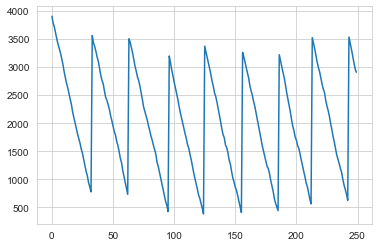

In [67]:
# Inventory Simulation
plt.plot(inventory_history)

In [40]:
# Stockouts
stockout_days = len(inventory_history) - np.count_nonzero(inventory_history)
stockout_days

0

In [41]:
# Orders
orders

8

In [42]:
# Time Between Orders
time_to_order = simulation_length/orders
time_to_order

31.25